In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
from   datetime          import timedelta

In [2]:
# Preparing data for portfolio

num_securities = 30
num_periods    = 200
start_date     = pd.to_datetime('2022-01-01')
end_date       = pd.to_datetime('2023-12-31')

trade_dates    = pd.to_datetime(np.sort(np.random.choice(pd.date_range(start=start_date, end=end_date, periods=num_periods + 1), num_periods, replace=False)))

df = pd.DataFrame({'datetime'  : trade_dates})
df['datetime' ] = pd.to_datetime(df['datetime'])
df['datetime_'] = df['datetime']
df = df.set_index('datetime')

outliers_percentage = 20.0
outliers_percentage = outliers_percentage/100.0 # percentage of all returns are outliers
outliers_count      = int(num_periods*outliers_percentage)

for idx in range(0, num_securities):
    percentage_changes = np.random.uniform(-0.045, 0.055, num_periods).astype(float)
    extreme_returns    = np.random.uniform(-0.09,  0.1, outliers_count).astype(float)
    outliers_date      = df['datetime_'].sample(n=outliers_count).to_list()
    df[f"return_{idx}"] = percentage_changes
    for outlier in list(zip(outliers_date, extreme_returns)):
        outlier_dt  = outlier[0]
        outlier_ret = outlier[1]
        df.loc[outlier_dt, f"return_{idx}"] = outlier_ret
    df[f"cum_ret_{idx}"  ] = df[f"return_{idx}"].cumsum()

df.drop('datetime_', axis=1, inplace=True)

df

,return_0,cum_ret_0,return_1,cum_ret_1,return_2,cum_ret_2,return_3,cum_ret_3,return_4,cum_ret_4,...,return_25,cum_ret_25,return_26,cum_ret_26,return_27,cum_ret_27,return_28,cum_ret_28,return_29,cum_ret_29
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,-0.008058,-0.008058,-0.009086,-0.009086,-0.025751,-0.025751,0.001144,0.001144,-0.031599,-0.031599,...,-0.062139,-0.062139,-0.000453,-0.000453,0.028568,0.028568,-0.044945,-0.044945,-0.034134,-0.034134
2022-01-04 15:28:48,-0.031071,-0.039129,0.012371,0.003285,0.075375,0.049625,0.015448,0.016592,0.006332,-0.025267,...,-0.089336,-0.151476,0.070563,0.070110,-0.004004,0.024564,-0.040580,-0.085524,0.014087,-0.020047
2022-01-08 06:57:36,0.030893,-0.008236,0.018352,0.021638,-0.039263,0.010361,0.051313,0.067905,-0.029959,-0.055226,...,-0.030916,-0.182391,0.020242,0.090352,-0.001572,0.022993,0.035256,-0.050268,-0.041034,-0.061081
2022-01-11 22:26:24,-0.017847,-0.026082,-0.026697,-0.005059,0.017158,0.027519,0.043870,0.111774,0.024178,-0.031048,...,0.049075,-0.133316,-0.016314,0.074038,-0.033620,-0.010627,-0.034237,-0.084505,0.041910,-0.019171
2022-01-15 13:55:12,0.028563,0.002481,0.051354,0.046294,0.037152,0.064671,-0.010046,0.101728,0.034919,0.003871,...,-0.035107,-0.168423,-0.041292,0.032746,0.046572,0.035945,0.006740,-0.077764,-0.034203,-0.053374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-16 10:04:48,0.099611,0.806186,-0.018715,1.018759,-0.027475,0.497145,0.028088,0.707430,0.002485,1.520793,...,-0.012602,1.097973,-0.010888,1.411923,-0.034897,1.739558,0.047085,0.911853,0.031144,1.023880
2023-12-20 01:33:36,-0.024907,0.781279,0.037351,1.056110,0.047313,0.544458,0.036366,0.743796,0.030664,1.551456,...,-0.035237,1.062736,-0.021120,1.390803,-0.042631,1.696927,0.051337,0.963190,0.064752,1.088632
2023-12-23 17:02:24,0.019579,0.800858,-0.006948,1.049163,-0.033594,0.510864,0.019572,0.763368,0.037846,1.589302,...,0.047651,1.110387,0.036535,1.427338,-0.044998,1.651929,-0.037728,0.925462,-0.007896,1.080736


<Axes: xlabel='datetime'>

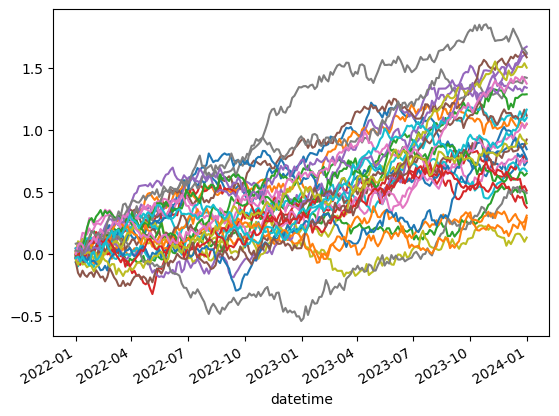

In [3]:
#for idx in range(0, num_securities):
#    df[f'cum_ret_{idx}'].plot()

df.filter(like='cum_ret_').plot(legend=False)

In [4]:
# Some notes on log returns
# Using log returns we can harness benefits of compounding effects and 
# easiliy incorporota transaction cost in this case it is rebalancing cost

In [5]:
# Baseline portfolio allocation with the volatility targeting
#
# - Initial allocation is equally weighted
# - Adjust weights based on the volatility of security
# - Rebalancing will be done in weekly basis
#
#

In [6]:
rebalancing_cost   = 0.001 # 0.1% aka 10bps as rebalancing cost
volatility_window  = 45

returns            = df.filter(like='return_')
log_returns        = (1+returns).apply(np.log)
rolling_volatility = log_returns.rolling(window=volatility_window).std()
rolling_volatility = rolling_volatility.ewm(span=5, adjust=False, min_periods=5).mean() # Fast EMA5 smoothing for volatility

weekly_log_returns = log_returns.resample('W').sum()

weights            = np.ones(num_securities)/num_securities # weights shape is (num_securities,0)
portfolio_returns  = pd.DataFrame(index=weekly_log_returns.index, columns=['Portfolio'])

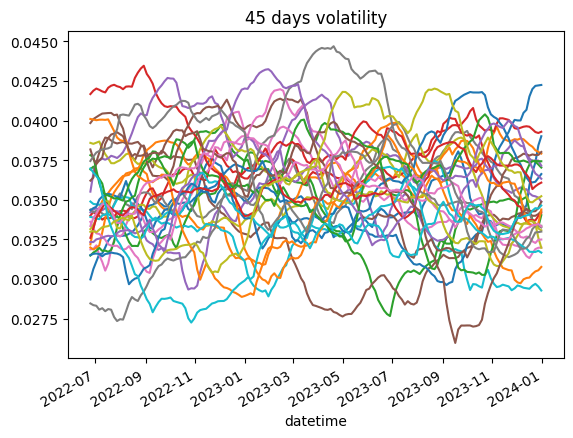

In [7]:
rolling_volatility.plot(legend=False)
plt.title(f'{volatility_window} days volatility');

<Axes: xlabel='datetime'>

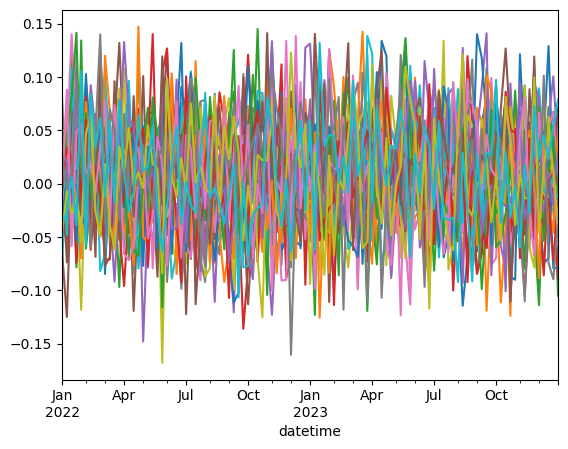

In [8]:
weekly_log_returns.plot(legend=False)